In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import requests
from alpha_vantage.foreignexchange import ForeignExchange 
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
api_key = "968U93YONJTBSCFS"   #My Api Key

In [3]:
# Initialize the ForeignExchange class
fx = ForeignExchange(key= "api_key", output_format="pandas")

In [24]:
# Get the daily exchange rates
data, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="KES", outputsize="full")

In [60]:
data.head(10)

,Open,High,Low,Close
date,,,,
2014-08-07,86.299,86.839,86.274,86.477
2014-08-10,86.534,87.900,86.307,86.406
2014-08-11,86.419,86.862,86.354,86.494
2014-08-12,86.504,86.970,86.403,86.610
2014-08-13,86.630,86.889,86.305,86.603
2014-08-14,86.615,87.034,86.498,86.602
2014-08-17,88.050,88.200,86.554,86.761
2014-08-18,86.761,87.179,86.601,86.852
2014-08-19,86.847,87.157,86.593,86.797


In [29]:
# Renaming columns
data.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [59]:
data = data.sort_index()

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2609 entries, 2024-08-08 to 2014-08-07
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2609 non-null   float64
 1   High    2609 non-null   float64
 2   Low     2609 non-null   float64
 3   Close   2609 non-null   float64
dtypes: float64(4)
memory usage: 101.9 KB


In [28]:
# Check for missing values
data.isnull().sum()

1. open     0
2. high     0
3. low      0
4. close    0
dtype: int64


In [32]:
# Summary statistics
data.describe()

              Open         High          Low        Close
count  2609.000000  2609.000000  2609.000000  2609.000000
mean    108.651702   109.318385   108.110320   108.705258
std      15.219350    15.131624    15.275586    15.211538
min      86.299000    86.839000    16.150000    86.406000
25%      99.820000   100.560000    99.346000    99.797000
50%     102.000000   102.850000   101.470000   102.000000
75%     112.650000   113.150000   112.450000   113.000000
max     162.990000   163.210010   161.570010   163.000000


# Stationarity Check

In [61]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(data['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.3919184215655587
p-value: 0.586144337743293
The series is non-stationary, differencing is required.


# Modeling
Differencing the Series

In [97]:
df_diff = data['Close'].diff().dropna()


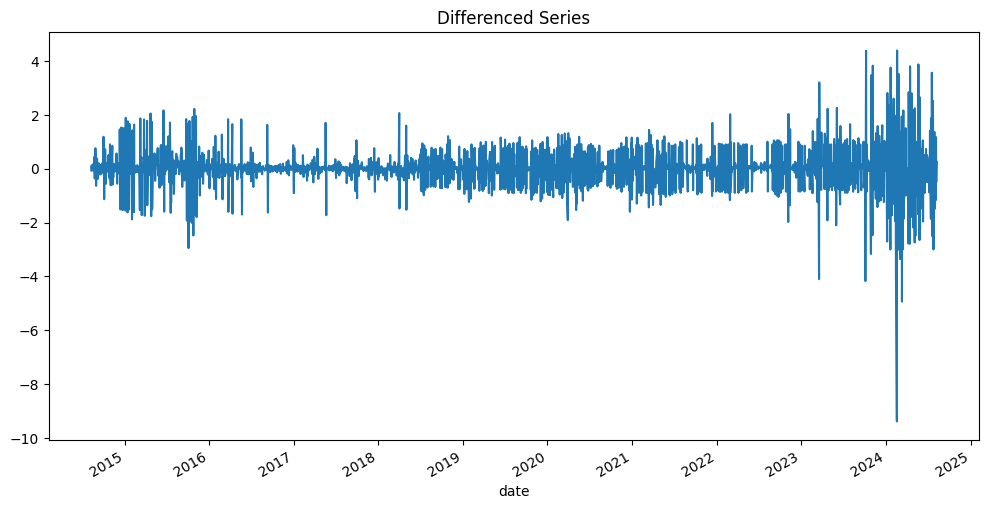

In [98]:
# Plot the differenced series
df_diff.plot(figsize=(12, 6))
plt.title('Differenced Series')
plt.show()

Determining ARIMA Parameters

We’ll use ACF and PACF plots to determine the parameters p, 𝑑 and 𝑞

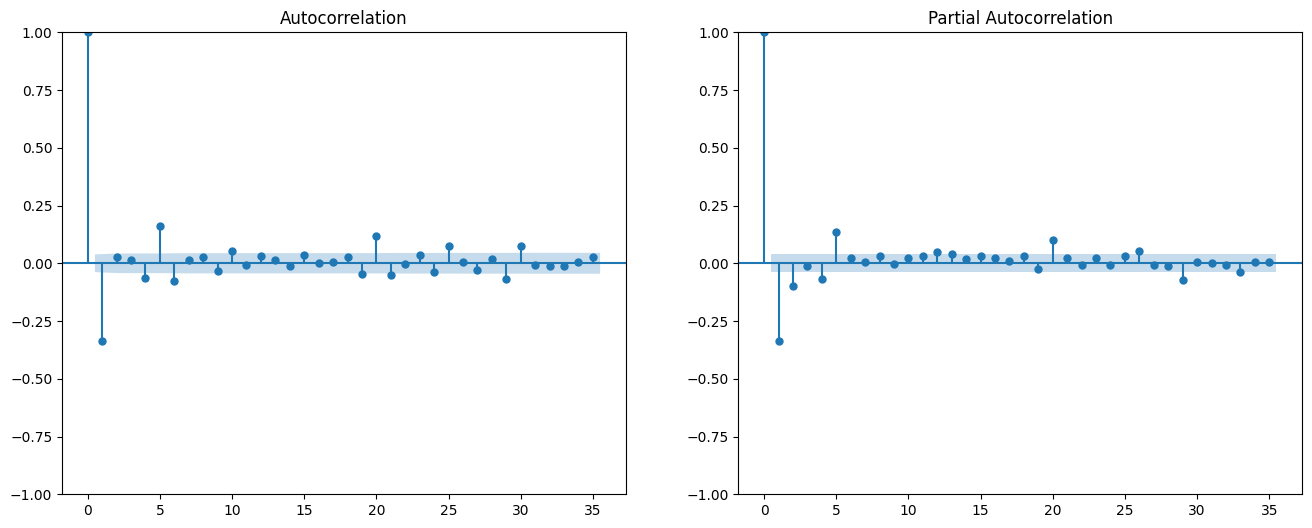

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_diff, ax=axes[0])
plot_pacf(df_diff, ax=axes[1])
plt.show()

Fitting the ARIMA Model

In [119]:
from statsmodels.tsa.arima.model import ARIMA

# Replace p, d, q with the values identified from ACF and PACF
model = ARIMA(data['Close'], order=(1, 1, 6))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. f

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2609
Model:                 ARIMA(1, 1, 6)   Log Likelihood               -2608.196
Date:                Thu, 08 Aug 2024   AIC                           5232.391
Time:                        17:43:09   BIC                           5279.322
Sample:                             0   HQIC                          5249.393
                               - 2609                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1831      0.198     -0.925      0.355      -0.571       0.205
ma.L1         -0.1792      0.197     -0.909      0.363      -0.566       0.207
ma.L2         -0.0359      0.071     -0.507      0.6

# Model Evaluation

Residual Analysis
- After fitting the model, it's important to check if the residuals (errors) are white noise.

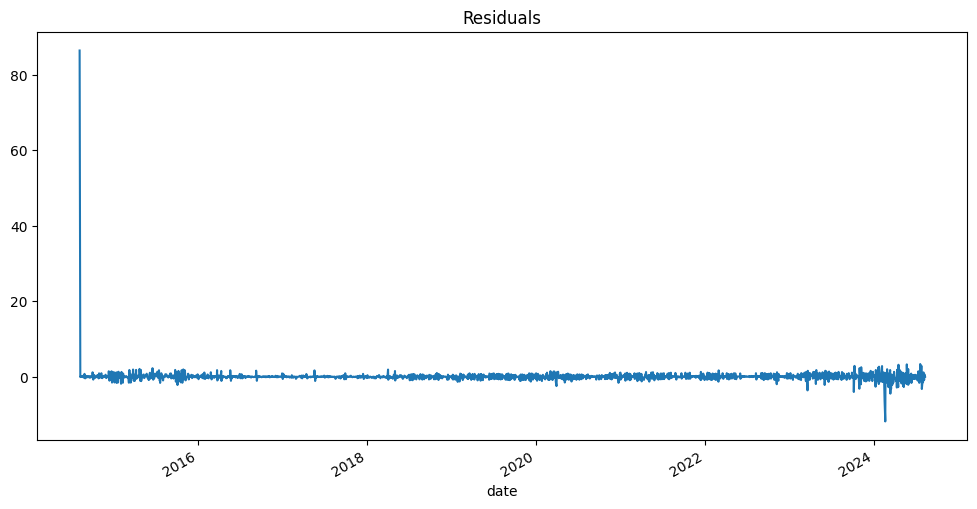

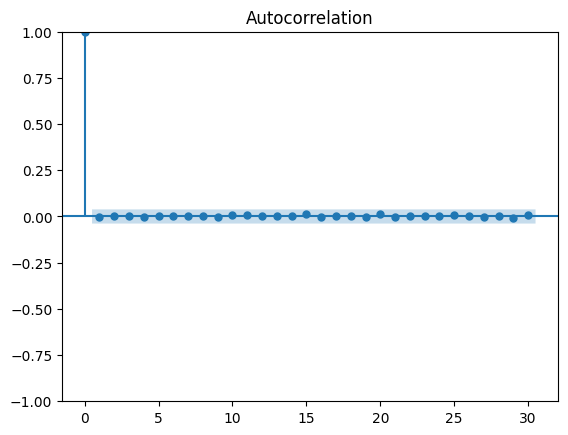

In [120]:
residuals = model_fit.resid

# Plot residuals
residuals.plot(figsize=(12, 6))
plt.title('Residuals')
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=30)
plt.show()

Forecast Accuracy
- We can evaluate the model’s accuracy by comparing the predicted values with the actual values.

In [121]:
from sklearn.metrics import mean_squared_error

# Get the predicted values
predictions = model_fit.predict(start=len(df_diff), end=len(df_diff) + len(df_diff)-1, dynamic=False)

# Calculate Mean Squared Error
mse = mean_squared_error(df_diff, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 16541.316173876483


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [122]:
data.tail()

,Open,High,Low,Close
date,,,,
2024-08-04,127.83,129.09,127.51281,127.83
2024-08-05,129.00,129.50,128.50000,129.00
2024-08-06,128.50,129.00,127.75000,128.50
2024-08-07,128.48,128.48,128.48000,128.48
2024-08-08,128.48,128.98,128.23000,128.73


In [123]:
# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

forecast

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2609    128.502000
2610    128.682068
2611    128.617955
2612    128.626672
2613    128.628628
2614    128.627053
2615    128.627342
2616    128.627289
2617    128.627298
2618    128.627297
2619    128.627297
2620    128.627297
2621    128.627297
2622    128.627297
2623    128.627297
2624    128.627297
2625    128.627297
2626    128.627297
2627    128.627297
2628    128.627297
2629    128.627297
2630    128.627297
2631    128.627297
2632    128.627297
2633    128.627297
2634    128.627297
2635    128.627297
2636    128.627297
2637    128.627297
2638    128.627297
Name: predicted_mean, dtype: float64

In [124]:
# Assuming `forecast` has 30 values
forecast_steps = len(forecast)


In [125]:

# Generate a date range with the same number of days as the forecast
forecast_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='B')[1:]
forecast_dates

DatetimeIndex(['2024-08-09', '2024-08-12', '2024-08-13', '2024-08-14',
               '2024-08-15', '2024-08-16', '2024-08-19', '2024-08-20',
               '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-26',
               '2024-08-27', '2024-08-28', '2024-08-29', '2024-08-30',
               '2024-09-02', '2024-09-03', '2024-09-04', '2024-09-05',
               '2024-09-06', '2024-09-09', '2024-09-10', '2024-09-11',
               '2024-09-12', '2024-09-13', '2024-09-16', '2024-09-17',
               '2024-09-18', '2024-09-19'],
              dtype='datetime64[ns]', freq='B')

In [126]:
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': forecast
})
forecast_df.set_index('Date', inplace=True)
forecast_df.head()

,Forecasted_Close
Date,
2024-08-09,128.502000
2024-08-12,128.682068
2024-08-13,128.617955
2024-08-14,128.626672
2024-08-15,128.628628


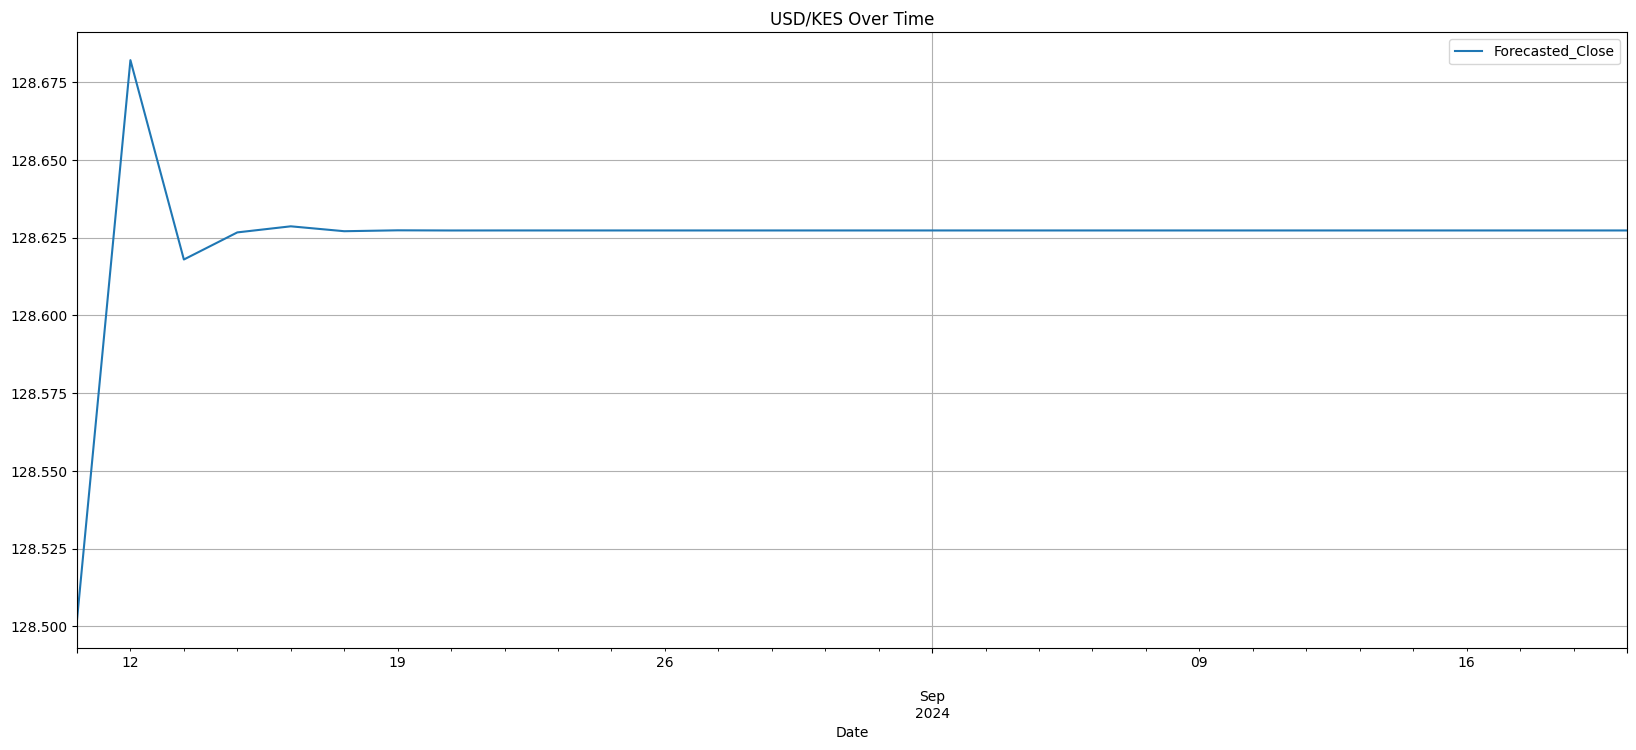

In [127]:
forecast_df.plot(figsize=(20,8))
plt.title("USD/KES Over Time")
plt.grid()
plt.show()

SARIMA MODEL

In [128]:
p, d, q = 1, 1, 1

In [129]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data["Close"], order=(p, d, q), seasonal_order=(p, d, q, 52))  
fitted = model.fit() 
print(fitted.summary())

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 2609
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -2678.015
Date:                            Thu, 08 Aug 2024   AIC                           5366.030
Time:                                    17:45:18   BIC                           5395.261
Sample:                                         0   HQIC                          5376.630
                                           - 2609                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1017      0.035     -2.878      0.004      -0.171      -0.032
ma.L1         -0.2657      0.032   

In [130]:
predictions = fitted.predict(len(data), len(data)+29)
predictions

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2609    128.630118
2610    128.719703
2611    128.396065
2612    128.661074
2613    128.544209
2614    128.681883
2615    128.722155
2616    128.727461
2617    128.953254
2618    128.701044
2619    129.065485
2620    129.290589
2621    129.012443
2622    129.188529
2623    129.168985
2624    129.343987
2625    129.299060
2626    129.229651
2627    129.289896
2628    129.329029
2629    129.171230
2630    129.422223
2631    129.784199
2632    129.763366
2633    129.644495
2634    129.723436
2635    129.813969
2636    130.009108
2637    129.940184
2638    129.947808
Name: predicted_mean, dtype: float64

In [131]:
prediction_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close': predictions
})
prediction_df.set_index('Date', inplace=True)
prediction_df.head()

,Forecasted_Close
Date,
2024-08-09,128.630118
2024-08-12,128.719703
2024-08-13,128.396065
2024-08-14,128.661074
2024-08-15,128.544209


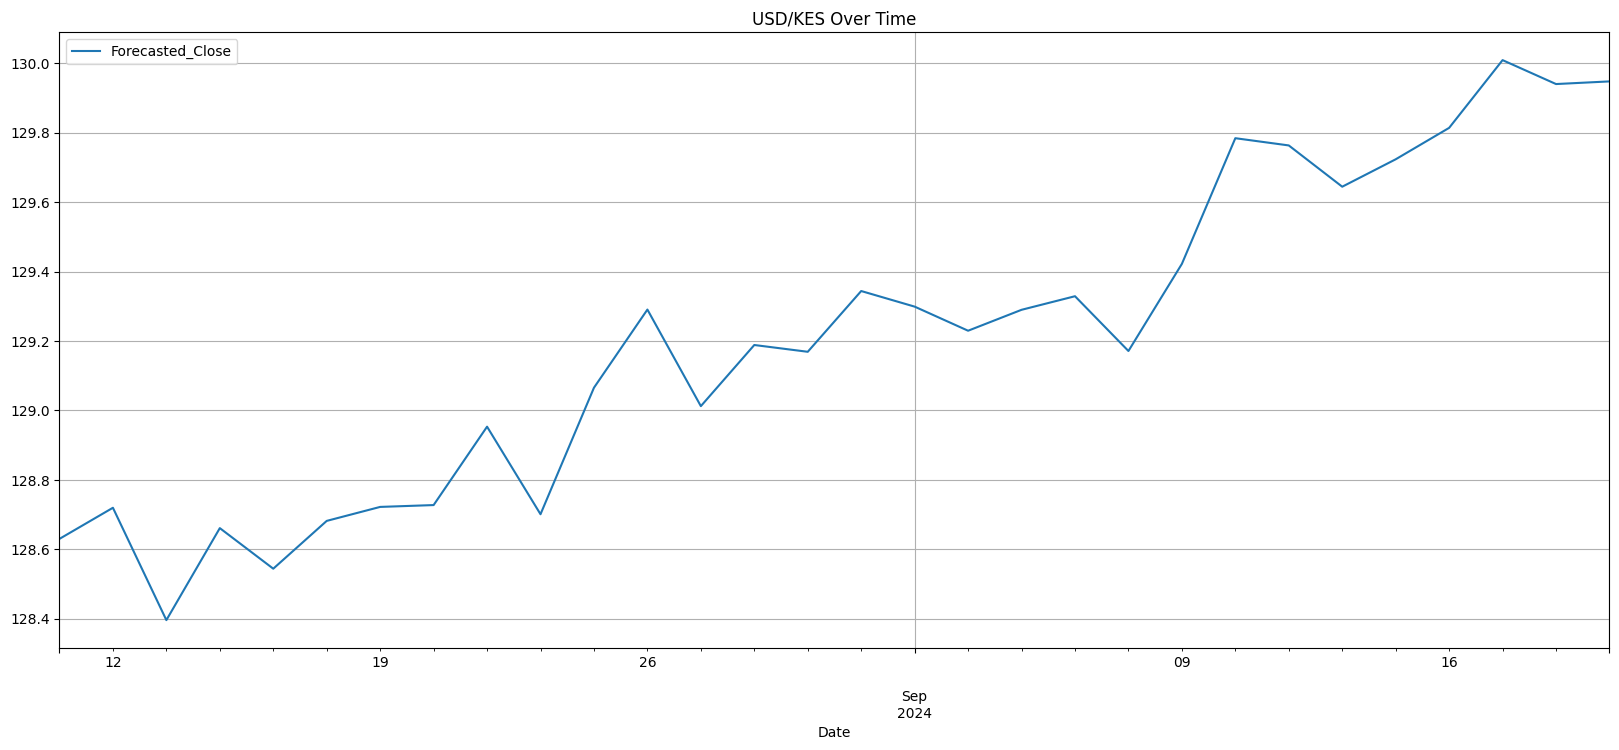

In [132]:
prediction_df.plot(figsize=(20,8))
plt.title("USD/KES Over Time")
plt.grid()
plt.show()